In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm

In [ ]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

class CustomTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image, target):
        return self.transform(image), target

# Define your transforms
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

custom_transform = CustomTransform(transform)

# Specify the directory for the dataset
root = '/kaggle/working/'  

# Initialize the dataset with the custom transform
full_dataset = datasets.SBDataset(root + 'train', image_set='train', mode='segmentation', transforms=custom_transform, download=True)

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [0.7, 0.2, 0.1])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
validation_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

# Example usage of the DataLoader
for images, targets in train_loader:
    print(f"Batch size: {images.shape}, Targets shape: {targets.shape}")  # Outputs shapes of images and targets
    break  # Remove this break to iterate through the entire dataset


100%|██████████| 1419539633/1419539633 [00:21<00:00, 66681378.59it/s]


Extracting /kaggle/working/train/benchmark.tgz to /kaggle/working/train


In [2]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize images (you can adjust this)
    transforms.ToTensor()
])

root = '/kaggle/working/'  # Specify the directory for the dataset

full_dataset = datasets.SBDataset(root, image_set='train', mode='segmentation', transforms=transform, download=True)

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [0.7, 0.2, 0.1])

# Step 3: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
validation_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

# Example usage of the DataLoader
for images, targets in train_loader:
    print(f"Batch size: {images.shape}, Targets shape: {targets.shape}")  # Outputs shapes of images and targets
    break  # Remove this break to iterate through the entire dataset

100%|██████████| 1419539633/1419539633 [00:34<00:00, 40737646.91it/s]


Extracting /kaggle/working/benchmark.tgz to /kaggle/working/


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 420, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/opt/conda/lib/python3.10/site-packages/torchvision/datasets/sbd.py", line 117, in __getitem__
    img, target = self.transforms(img, target)
TypeError: Compose.__call__() takes 2 positional arguments but 3 were given


In [6]:
class attention_unet(nn.Module):
    def __init__(self):
        super(attention_unet, self).__init__()

        # encoder blocks
        self.enc1_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc1_bn1 = nn.BatchNorm2d(64)
        self.enc1_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.enc1_bn2 = nn.BatchNorm2d(64)

        self.enc2_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc2_bn1 = nn.BatchNorm2d(128)
        self.enc2_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc2_bn2 = nn.BatchNorm2d(128)

        self.enc3_conv1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc3_bn1 = nn.BatchNorm2d(256)
        self.enc3_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc3_bn2 = nn.BatchNorm2d(256)

        self.enc4_conv1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc4_bn1 = nn.BatchNorm2d(512)
        self.enc4_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc4_bn2 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck_conv1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bottleneck_bn1 = nn.BatchNorm2d(1024)
        self.bottleneck_conv2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bottleneck_bn2 = nn.BatchNorm2d(1024)

        # attention gates
        self.att_conv1 = nn.Conv2d(512, 256, kernel_size=1, padding=0)
        self.att_conv2 = nn.Conv2d(256, 256, kernel_size=1, padding=0)
        self.att_conv3 = nn.Conv2d(256, 1, kernel_size=1, padding=0)

        # decoder_block
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dec1_conv1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec1_bn1 = nn.BatchNorm2d(512)
        self.dec1_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dec1_bn2 = nn.BatchNorm2d(512)

        self.dec2_conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec2_bn1 = nn.BatchNorm2d(256)
        self.dec2_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.dec2_bn2 = nn.BatchNorm2d(256)

        self.dec3_conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec3_bn1 = nn.BatchNorm2d(128)
        self.dec3_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dec3_bn2 = nn.BatchNorm2d(128)

        self.dec4_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec4_bn1 = nn.BatchNorm2d(64)
        self.dec4_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec4_bn2 = nn.BatchNorm2d(64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, x, out_channels):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

    def encoder_block(self, x, conv1, bn1, conv2, bn2):
        x = F.relu(bn1(conv1(x)))
        x = F.relu(bn2(conv2(x)))
        p = self.pool(x)
        return x, p

#     def attention_gate(self, g, x, out_channels):
#         theta_x = self.att_conv1(x)
#         phi_g = self.att_conv2(g)
#         sum_xg = F.relu(theta_x + phi_g)
#         psi = torch.sigmoid(self.att_conv3(sum_xg))
#         return x * psi

    def decoder_block(self, x, skip_features, upconv, conv1, bn1, conv2, bn2):
        x = upconv(x)
        x = torch.cat((x, skip_features), dim=1)
        x = F.relu(bn1(conv1(x)))
        x = F.relu(bn2(conv2(x)))
        return x

    def forward(self, x):
        s1, p1 = self.encoder_block(x, self.enc1_conv1, self.enc1_bn1, self.enc1_conv2, self.enc1_bn2)  # 256
        s2, p2 = self.encoder_block(p1, self.enc2_conv1, self.enc2_bn1, self.enc2_conv2, self.enc2_bn2)  # 128
        s3, p3 = self.encoder_block(p2, self.enc3_conv1, self.enc3_bn1, self.enc3_conv2, self.enc3_bn2)  # 64
        s4, p4 = self.encoder_block(p3, self.enc4_conv1, self.enc4_bn1, self.enc4_conv2, self.enc4_bn2)  # 32

        b1 = F.relu(self.bottleneck_bn1(self.bottleneck_conv1(p4)))  # 16
        b1 = F.relu(self.bottleneck_bn2(self.bottleneck_conv2(b1)))  # 16

        d1 = self.decoder_block(b1, s4, self.upconv1, self.dec1_conv1, self.dec1_bn1, self.dec1_conv2, self.dec1_bn2)
        d2 = self.decoder_block(d1, s3, self.upconv2, self.dec2_conv1, self.dec2_bn1, self.dec2_conv2, self.dec2_bn2)
        d3 = self.decoder_block(d2, s2, self.upconv3, self.dec3_conv1, self.dec3_bn1, self.dec3_conv2, self.dec3_bn2)
        d4 = self.decoder_block(d3, s1, self.upconv4, self.dec4_conv1, self.dec4_bn1, self.dec4_conv2, self.dec4_bn2)

        attn = torch.sigmoid(self.final_conv(d4))  # 512
        
        return attn
    
model = attention_unet()

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model = model.to(device)
model.to(device)

Let's use 2 GPUs!


DataParallel(
  (module): attention_unet(
    (enc1_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc1_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc1_bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2_conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc2_bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2_conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc2_bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc3_conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc3_bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc3_conv2): Conv2d(256, 256, kernel_size=(3, 

In [8]:
l1_lambda=0.001
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)   
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [9]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
count_parameters(model)

+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
|    module.enc1_conv1.weight    |    1728    |
|     module.enc1_conv1.bias     |     64     |
|     module.enc1_bn1.weight     |     64     |
|      module.enc1_bn1.bias      |     64     |
|    module.enc1_conv2.weight    |   36864    |
|     module.enc1_conv2.bias     |     64     |
|     module.enc1_bn2.weight     |     64     |
|      module.enc1_bn2.bias      |     64     |
|    module.enc2_conv1.weight    |   73728    |
|     module.enc2_conv1.bias     |    128     |
|     module.enc2_bn1.weight     |    128     |
|      module.enc2_bn1.bias      |    128     |
|    module.enc2_conv2.weight    |   147456   |
|     module.enc2_conv2.bias     |    128     |
|     module.enc2_bn2.weight     |    128     |
|      module.enc2_bn2.bias      |    128     |
|    module.enc3_conv1.weight    |   294912   |
|     module.enc3_conv1.bias     |    25

31240898

In [10]:
# class DiceLoss(nn.Module):
#     def __init__(self, smooth=1.0):
#         super(DiceLoss, self).__init__()
#         self.smooth = smooth

#     def forward(self, preds, targets):
#         preds = preds.sigmoid()  # Apply sigmoid if using BCE
#         preds = (preds > 0.5).float()  # Binarize the predictions
#         intersection = (preds * targets).sum()
#         return 1 - (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)

# criterion = DiceLoss()

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    correct_predictions = 0
    total_pixels = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in tqdm(validation_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Calculate accuracy
            # Get predicted class by taking the argmax over the channel dimension
            preds = torch.argmax(outputs, dim=1)

            # Compare predictions to true labels
            correct_predictions += (preds == labels).sum().item()
            total_pixels += labels.numel()

    # Average loss and accuracy for the validation set
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_accuracy = correct_predictions / total_pixels

    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}%")

  0%|          | 0/90 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 90/90 [01:26<00:00,  1.03it/s]


Epoch [1/10], Loss: 0.7606


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
preds[0]

In [41]:
model.eval()
for inputs, labels in validation_loader:
    with torch.no_grad():
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
    break       

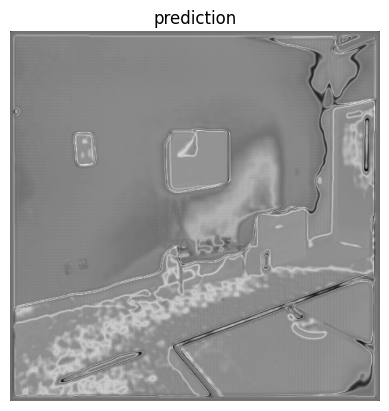

In [42]:
import matplotlib.pyplot as plt
plt.imshow(inputs[0].cpu().permute(1,2,0))
plt.axis('off')  # Hide axes
plt.title('input')
plt.show()

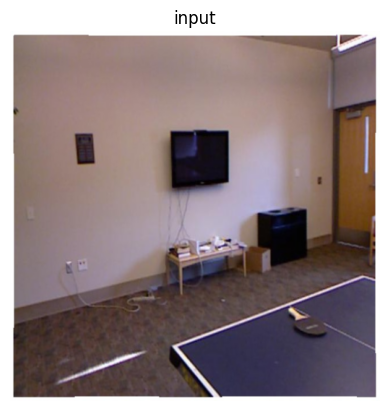

In [43]:
plt.imshow(outputs[0].cpu().squeeze(0), cmap='gray')
plt.axis('off')  # Hide axes
plt.title('prediction')
plt.show()

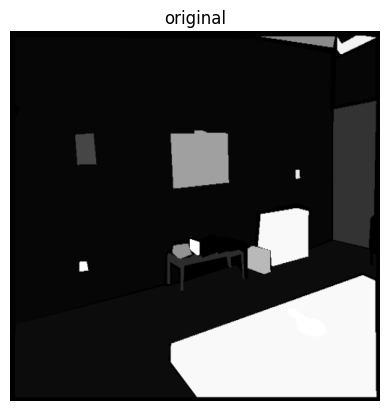

In [44]:
plt.imshow(labels[0].cpu().squeeze(0), cmap='gray')
plt.axis('off')  # Hide axes
plt.title('original')
plt.show()